In [7]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen import Composition, Element
from data_extraction_rxn_classification import *
from data_featurization import *
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
from collections import Counter
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
def clean_formulas(formula_list):
    chem_list = [re.sub("([0-9]+(\.[0-9]+)?)", "_{\\1}", k) for k in formula_list]
    chem_list = ['$\mathregular{'+list_k+'}$' for list_k in chem_list]
    return chem_list
def clean_formula(formula):
    return '$\\mathregular{' + re.sub("([0-9]+(\.[0-9]+)?)", "_{\\1}", formula) + '}$'

In [2]:
all_elements = [Element.from_Z(i).symbol for i in range(1, 119)]

In [3]:
with open('../data/solid-state_dataset_20200713.json') as f:
    ss_data= json.load(f)
ss_reactions = ss_data["reactions"]
ss_extracted, ss_precursor_nomenclature = extract_solidstate(ss_reactions)
ss_no_duplicates = remove_duplicates(ss_extracted)

Returning extracted data of 26787/31782 reactions.
After removing duplicates, remaining extracted data contains 16010/26787 reactions.


In [4]:
with open('../data/sol-gel_dataset_20200713.json') as f:
    sg_data= json.load(f)
sg_reactions = sg_data["reactions"]
sg_extracted, sg_precursor_nomenclature = extract_solgel(sg_reactions)
sg_no_duplicates = remove_duplicates(sg_extracted)

Returning extracted data of 6854/9518 reactions.
After removing duplicates, remaining extracted data contains 4146/6854 reactions.


In [5]:
with open('../data/solution-synthesis_dataset_2021-8-5.json') as f:
    sol_data= json.load(f)
sol_extracted, sol_precursor_nomenclature = extract_solution(sol_data)
sol_no_duplicates = remove_duplicates(sol_extracted, solution=True)

/home/synthesisproject/anaconda3/envs/syn_gen/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:441: UserWarning: No electronegativity for Hs. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


Returning extracted data of 14116/35675 reactions.
After removing duplicates, remaining extracted data contains 5686/14116 reactions.


In [9]:
for rxn in ss_no_duplicates:
    if all('NO3' in prec for prec in rxn['precursors']):
        print(rxn)

{'target': 'CaAl2O4', 'precursors': ['Al(NO3)3', 'Ca(NO3)2'], 'DOIs': ['10.1021/acs.inorgchem.7b01655'], 'count': 1}
{'target': 'Ca3Al2O6', 'precursors': ['Al(NO3)3', 'Ca(NO3)2'], 'DOIs': ['10.1021/acs.inorgchem.7b01655'], 'count': 1}
{'target': 'Y3Al5O12', 'precursors': ['Al(NO3)3', 'Y(NO3)3'], 'DOIs': ['10.1016/j.cplett.2008.09.045', '10.1016/s0924-2031(98)00051-4'], 'count': 2}
{'target': 'LaInO3', 'precursors': ['In(NO3)3', 'La(NO3)3'], 'DOIs': ['10.1016/j.materresbull.2012.01.031'], 'count': 1}
{'target': 'Sr0.4La0.6Fe0.2Co0.8O3', 'precursors': ['Co(NO3)2', 'Fe(NO3)3', 'La(NO3)2', 'Sr(NO3)2'], 'DOIs': ['10.1016/j.scriptamat.2003.09.008'], 'count': 1}
{'target': 'La1Al0.9Ni0.1O3', 'precursors': ['Al(NO3)3', 'La(NO3)3', 'Ni(NO3)2'], 'DOIs': ['10.1016/s1566-7367(01)00060-7'], 'count': 1}
{'target': 'Al5(FeO4)3', 'precursors': ['Al(NO3)3', 'Fe(NO3)3'], 'DOIs': ['10.1016/j.chemphys.2005.08.055'], 'count': 1}
{'target': 'Ca3Co4O9', 'precursors': ['Ca(NO3)2', 'Co(NO3)2'], 'DOIs': ['10.10

# Remove all reactions that take place in more than one category


In [10]:
all_three = []
ss_sg = []
sol_sg = []
for sg_rxn in sg_no_duplicates:
    found_ss_rxn = None
    found_sol_rxn = None
    for ss_rxn in ss_no_duplicates:
        if sg_rxn['target'] == ss_rxn['target'] and set(sg_rxn['precursors']) == set(ss_rxn['precursors']):
            found_ss_rxn = ss_rxn
            break
    for sol_rxn in sol_no_duplicates:
        if sg_rxn['target'] == sol_rxn['target'] and set(sg_rxn['precursors']) == set(sol_rxn['precursors']):
            found_sol_rxn = sol_rxn
            break
    if found_ss_rxn and found_sol_rxn:
        all_three.append({
        'target': sg_rxn['target'],
        'precursors': sg_rxn['precursors'],
        'ss_dois': ss_rxn['DOIs'],
        'sg_dois': sg_rxn['DOIs'],
        'sol_dois': sol_rxn['DOIs'],
        'type': sol_rxn['type']
    })
    elif found_ss_rxn:
        ss_sg.append({
            'target': sg_rxn['target'],
            'precursors': sg_rxn['precursors'],
            'ss_dois': ss_rxn['DOIs'],
            'sg_dois': sg_rxn['DOIs'],
            'sol_dois': []
        })
    elif found_sol_rxn:
        sol_sg.append({
        'target': sg_rxn['target'],
        'precursors': sg_rxn['precursors'],
        'ss_dois': [],
        'sg_dois': sg_rxn['DOIs'],
        'sol_dois': sol_rxn['DOIs'],
        'type': sol_rxn['type']
        })

In [11]:
ss_sol = []
for ss_rxn in ss_no_duplicates:
    found_sg_rxn = None
    found_sol_rxn = None
    for sg_rxn in sg_no_duplicates:
        if sg_rxn['target'] == ss_rxn['target'] and set(sg_rxn['precursors']) == set(ss_rxn['precursors']):
            found_sg_rxn = sg_rxn
            break
    for sol_rxn in sol_no_duplicates:
        if sg_rxn['target'] == sol_rxn['target'] and set(sg_rxn['precursors']) == set(sol_rxn['precursors']):
            found_sol_rxn = sol_rxn
            break
    if found_sg_rxn and found_sol_rxn:
        continue
    elif found_sg_rxn:
        continue
    elif found_sol_rxn:
        ss_sol.append({
        'target': ss_rxn['target'],
        'precursors': ss_rxn['precursors'],
        'ss_dois': ss_rxn['DOIs'],
        'sg_dois': [],
        'sol_dois': sol_rxn['DOIs'],
        'type': sol_rxn['type']
        })

In [12]:
print(len(ss_sol), len(ss_sg), len(sol_sg), len(all_three))

0 140 212 31


In [13]:
only_sg_rxns = []
only_ss_rxns = []
only_sol_rxns = []
for sg_rxn in sg_no_duplicates:
    found = False
    for dup_rxn in ss_sg + all_three + sol_sg:
        if sg_rxn['target'] == dup_rxn['target'] and set(sg_rxn['precursors']) == set(dup_rxn['precursors']):
            found = True
    if not found:
        only_sg_rxns.append(sg_rxn)
    
for ss_rxn in ss_no_duplicates:
    found = False
    for dup_rxn in ss_sg + all_three + ss_sol:
        if ss_rxn['target'] == dup_rxn['target'] and set(ss_rxn['precursors']) == set(dup_rxn['precursors']):
            found = True
    if not found:
        only_ss_rxns.append(ss_rxn)
for sol_rxn in sol_no_duplicates:
    found = False
    for dup_rxn in sol_sg + all_three + ss_sol:
        if sol_rxn['target'] == dup_rxn['target'] and set(sol_rxn['precursors']) == set(dup_rxn['precursors']):
            found = True
    if not found:
        only_sol_rxns.append(sol_rxn)

In [14]:
print(len(sg_no_duplicates), len(ss_no_duplicates), len(sol_no_duplicates))
print(len(only_sg_rxns), len(only_ss_rxns), len(only_sol_rxns))

4146 16010 5686
3763 15839 5443


In [15]:
only_prec_rxns = []
only_hyd_rxns = []
for rxn in only_sol_rxns:
    ct = Counter(rxn['type'])
    if ct['precipitation'] <= ct['hydrothermal']:
        only_hyd_rxns.append(rxn)
    else:
        only_prec_rxns.append(rxn)

In [16]:
print(len(only_hyd_rxns), len(only_prec_rxns))

3324 2119


In [17]:
# allocate ambiguous rxns based on doi presence
for rxn in ss_sg:
    if len(rxn['sg_dois']) > len(rxn['ss_dois']):
        only_sg_rxns.append(rxn)
    else:
        only_ss_rxns.append(rxn)
for rxn in sol_sg:
    if len(rxn['sol_dois']) > len(rxn['sg_dois']):
        ct = Counter(rxn['type'])
        if ct['precipitation'] <= ct['hydrothermal']:
            only_hyd_rxns.append(rxn)
        else:
            only_prec_rxns.append(rxn)
        only_sol_rxns.append(rxn)
    else:
        only_sg_rxns.append(rxn)
for rxn in all_three:
    if len(rxn['ss_dois']) >= len(rxn['sg_dois']) and len(rxn['ss_dois']) >= len(rxn['sol_dois']):
        only_ss_rxns.append(rxn)
    elif len(rxn['sg_dois']) >= len(rxn['ss_dois']) and len(rxn['sg_dois']) >= len(rxn['sol_dois']):
        only_sg_rxns.append(rxn)
    else:
        ct = Counter(rxn['type'])
        if ct['precipitation'] <= ct['hydrothermal']:
            only_hyd_rxns.append(rxn)
        else:
            only_prec_rxns.append(rxn)
        only_sol_rxns.append(rxn)

In [18]:
print(len(only_sg_rxns), len(only_ss_rxns), len(only_hyd_rxns), len(only_prec_rxns))

3979 15937 3362 2150


In [20]:
print(len(only_hyd_rxns) + len(only_prec_rxns), len(only_sol_rxns))

5512 5512


# Visualize precursor frequency and distribution

In [21]:
ss_precs_all = []
sg_precs_all = []
sol_precs_all = []
hyd_precs_all = []
prec_precs_all = []
for rxn in only_ss_rxns:
    ss_precs_all.extend(rxn['precursors'])
for rxn in only_sg_rxns:
    sg_precs_all.extend(rxn['precursors'])
for rxn in only_sol_rxns:
    sol_precs_all.extend(rxn['precursors'])
for rxn in only_hyd_rxns:
    hyd_precs_all.extend(rxn['precursors'])
for rxn in only_prec_rxns:
    prec_precs_all.extend(rxn['precursors'])
# convert to most common nomenclature
ss_precs_all = [ss_precursor_nomenclature[Composition(x)] for x in ss_precs_all]
sg_precs_all = [sg_precursor_nomenclature[Composition(x)] for x in sg_precs_all]
sol_precs_all = [sol_precursor_nomenclature[Composition(x)] for x in sol_precs_all]
hyd_precs_all = [sol_precursor_nomenclature[Composition(x)] for x in hyd_precs_all]
prec_precs_all = [sol_precursor_nomenclature[Composition(x)] for x in prec_precs_all]

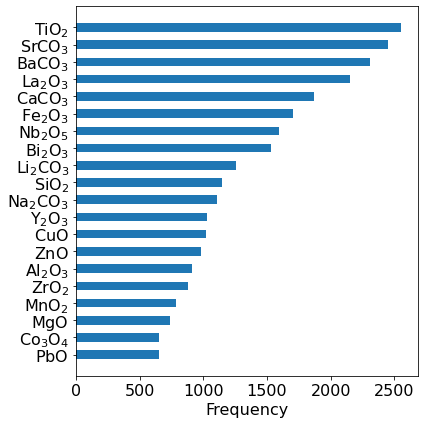

In [54]:
# solid-state
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ss_top_precs = pd.Series(ss_precs_all).value_counts().head(20).keys()
ss_top_freqs = pd.Series(ss_precs_all).value_counts().head(20).values
ax.barh(y=clean_formulas(ss_top_precs), width=ss_top_freqs, height=0.5)
plt.gca().invert_yaxis()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel("Frequency", fontsize=16)
fig.tight_layout()
plt.show()

# fig.savefig('figures/top_ss_precs.png', dpi=150)

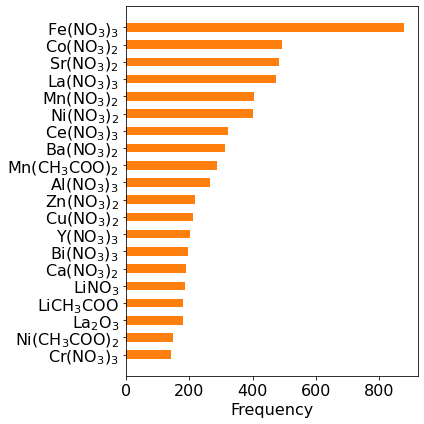

In [55]:
# sol-gel
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sg_top_precs = pd.Series(sg_precs_all).value_counts().head(20).keys()
sg_top_freqs = pd.Series(sg_precs_all).value_counts().head(20).values
ax.barh(y=clean_formulas(sg_top_precs), width=sg_top_freqs, height=0.5, color="C1")
plt.gca().invert_yaxis()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel("Frequency", fontsize=16)
fig.tight_layout()
plt.show()

# fig.savefig('figures/top_sg_precs.png', dpi=150)

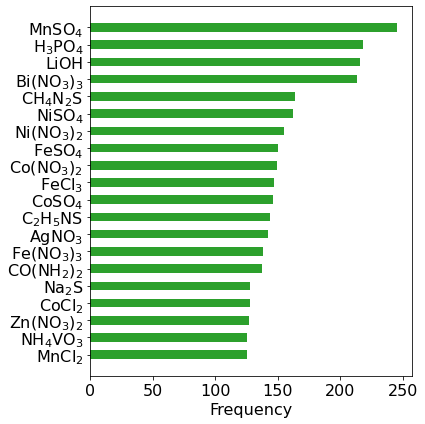

In [56]:
# solution
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sol_top_precs = pd.Series(sol_precs_all).value_counts().head(20).keys()
sol_top_freqs = pd.Series(sol_precs_all).value_counts().head(20).values
ax.barh(y=clean_formulas(sol_top_precs), width=sol_top_freqs, height=0.5, color="C2")
plt.gca().invert_yaxis()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel("Frequency", fontsize=16)
# ax.set_ylabel("Precursor", fontsize=14)
fig.tight_layout()
plt.show()

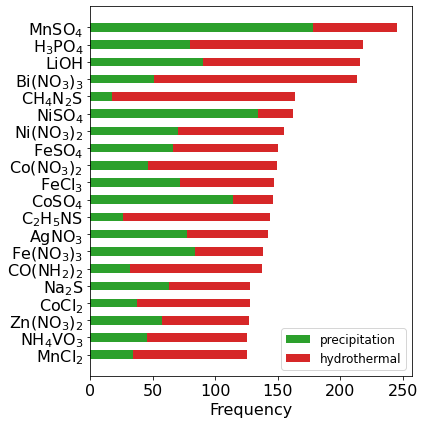

In [57]:
# solution
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sol_top_precs = pd.Series(sol_precs_all).value_counts().head(20).keys()
sol_prec_top_freqs = [Counter(prec_precs_all)[x] for x in sol_top_precs]
sol_hyd_top_freqs = [Counter(hyd_precs_all)[x] for x in sol_top_precs]

ax.barh(y=clean_formulas(sol_top_precs), width=sol_prec_top_freqs, height=0.5, color="C2", label="precipitation")
ax.barh(y=clean_formulas(sol_top_precs), width=sol_hyd_top_freqs, height=0.5, color="C3", left=sol_prec_top_freqs, label="hydrothermal")
plt.gca().invert_yaxis()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel("Frequency", fontsize=16)
# ax.set_ylabel("Precursor", fontsize=14)
ax.legend(fontsize=12)
fig.tight_layout()
plt.show()

# fig.savefig('figures/top_prec_hyd_precs.png', dpi=150)

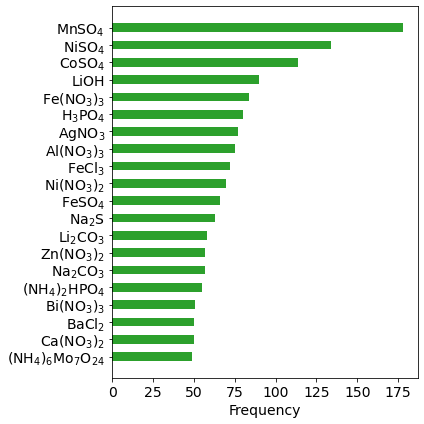

In [58]:
# precipitation
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
prec_top_precs = pd.Series(prec_precs_all).value_counts().head(20).keys()
prec_top_freqs = pd.Series(prec_precs_all).value_counts().head(20).values
ax.barh(y=clean_formulas(prec_top_precs), width=prec_top_freqs, height=0.5, color="C2")
plt.gca().invert_yaxis()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlabel("Frequency", fontsize=14)
# ax.set_ylabel("Precursor", fontsize=14)
fig.tight_layout()
plt.show()

# fig.savefig('figures/top_prec_precs.png', dpi=150)

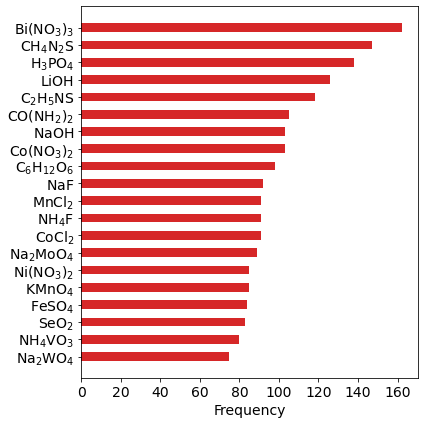

In [59]:
# hydrothermal
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
hyd_top_precs = pd.Series(hyd_precs_all).value_counts().head(20).keys()
hyd_top_freqs = pd.Series(hyd_precs_all).value_counts().head(20).values
ax.barh(y=clean_formulas(hyd_top_precs), width=hyd_top_freqs, height=0.5, color="C3")
plt.gca().invert_yaxis()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlabel("Frequency", fontsize=14)
# ax.set_ylabel("Precursor", fontsize=14)
fig.tight_layout()
plt.show()

# fig.savefig('figures/top_hyd_precs.png', dpi=150)

In [60]:
m_anions = ['H2PO4', 'HPO4', 'HCO3', 'HSO4', 'HSO3', 'C2O4']
d_anions = ['CO3', 'PO4', 'PO3', 'OH', 'NH4', 'NO3', 'NO2', 'SO4', 'SO3', 'CN'] #BO3, VO4, NH2
s_anions = ['F', 'B', 'P', 'Cl', 'F', 'Br', 'S', 'N', 'O', 'C']
ions = m_anions + d_anions + s_anions + ['Org'] + ['Ac'] + ['Elem'] + ['Other']
ss_anion_dict = {x: [] for x in ions}

In [61]:
for prec in ss_precs_all:
    found = False
    # check acetate first
    if 'CH3COO' in prec:
        ss_anion_dict['Ac'].append(prec)
        found = True
    # check organic
    elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
        ss_anion_dict['Org'].append(prec)
        found = True
    else:
        for anion in ions:
            # special check for elemental anions
            if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                ss_anion_dict[anion].append(prec)
                found = True
                break
    if not found:
        # check if precursor is elemental
        if prec in all_elements:
            ss_anion_dict['Elem'].append(prec)
        else:
            ss_anion_dict['Other'].append(prec)

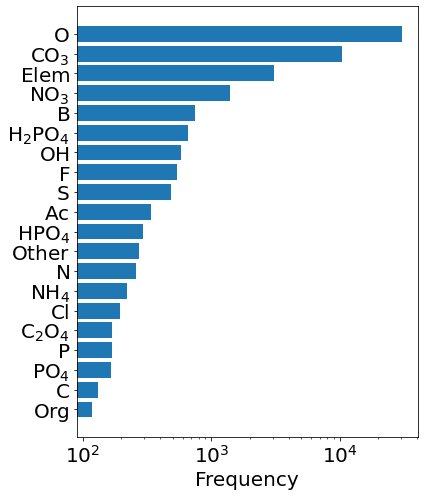

In [62]:
to_plot_ss = {key: len(ss_anion_dict[key]) for key in ss_anion_dict} 
to_plot_ss = {k: v for k, v in sorted(to_plot_ss.items(), key=lambda item: item[1])}
fig, ax = plt.subplots(1, 1, figsize=(6, 7))
ax.barh(y=clean_formulas(list(to_plot_ss.keys())[-20:]), width=list(to_plot_ss.values())[-20:], log=True, height=0.8)

ax.set_xlabel("Frequency", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fig.tight_layout()
plt.show()

# fig.savefig('figures/top_ss_anions.png', dpi=150)

In [63]:
# sg_anion_dict = {x["e_name"]: [] for x in anions[::-1]}
sg_anion_dict = {x: [] for x in ions}

In [64]:
for prec in sg_precs_all:
    found = False
    # check acetate first
    if 'CH3COO' in prec:
        sg_anion_dict['Ac'].append(prec)
        found = True
    # check organic
    elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
        sg_anion_dict['Org'].append(prec)
        found = True
    else:
        for anion in ions:
            # special check for elemental anions
            if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                sg_anion_dict[anion].append(prec)
                found = True
                break
    if not found:
        # check if precursor is elemental
        if prec in all_elements:
            sg_anion_dict['Elem'].append(prec)
        else:
            sg_anion_dict['Other'].append(prec)

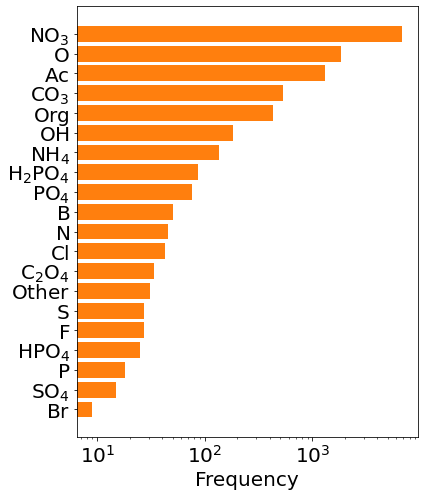

In [65]:
to_plot_sg = {key: len(sg_anion_dict[key]) for key in sg_anion_dict} 
to_plot_sg = {k: v for k, v in sorted(to_plot_sg.items(), key=lambda item: item[1])}
fig, ax = plt.subplots(1, 1, figsize=(6, 7))
ax.barh(y=clean_formulas(list(to_plot_sg.keys())[-20:]), width=list(to_plot_sg.values())[-20:], log=True, height=0.8, color="C1")

ax.set_xlabel("Frequency", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fig.tight_layout()
plt.show()

# fig.savefig('figures/top_sg_anions.png', dpi=150)

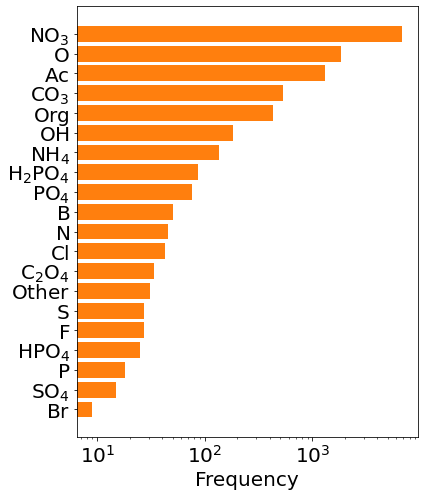

In [66]:
to_plot_sg = {key: len(sg_anion_dict[key]) for key in sg_anion_dict} 
to_plot_sg = {k: v for k, v in sorted(to_plot_sg.items(), key=lambda item: item[1])}
fig, ax = plt.subplots(1, 1, figsize=(6, 7))
ax.barh(y=clean_formulas(list(to_plot_sg.keys())[-20:]), width=list(to_plot_sg.values())[-20:], log=True, height=0.8, color="C1")

ax.set_xlabel("Frequency", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fig.tight_layout()
plt.show()

# fig.savefig('figures/top_sg_anions.png', dpi=150)

In [67]:
# sol_anion_dict = {x["e_name"]: [] for x in anions[::-1]}
sol_anion_dict = {x: [] for x in ions}

In [68]:
for prec in sol_precs_all:
    found = False
    # check acetate first
    if 'CH3COO' in prec:
        sol_anion_dict['Ac'].append(prec)
        found = True
    # check organic
    elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
        sol_anion_dict['Org'].append(prec)
        found = True
    else:
        for anion in ions:
            # special check for elemental anions
            if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                sol_anion_dict[anion].append(prec)
                found = True
                break
    if not found:
        # check if precursor is elemental
        if prec in all_elements:
            sol_anion_dict['Elem'].append(prec)
        else:
            sol_anion_dict['Other'].append(prec)

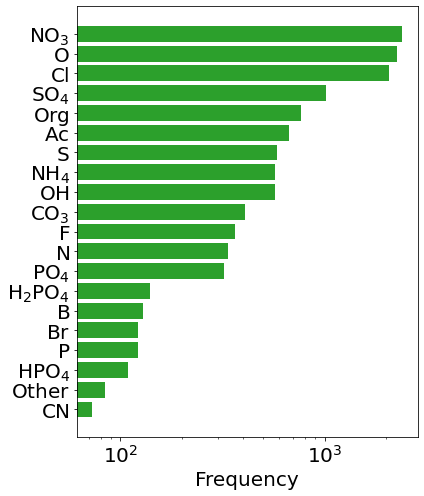

In [69]:
to_plot_sol = {key: len(sol_anion_dict[key]) for key in sol_anion_dict} 
to_plot_sol = {k: v for k, v in sorted(to_plot_sol.items(), key=lambda item: item[1])}
fig, ax = plt.subplots(1, 1, figsize=(6, 7))
ax.barh(y=clean_formulas(list(to_plot_sol.keys())[-20:]), width=list(to_plot_sol.values())[-20:], log=True, height=0.8, color="C2")

ax.set_xlabel("Frequency", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fig.tight_layout()
plt.show()

# fig.savefig('figures/top_sol_anions.png', dpi=150)

In [70]:
hyd_anion_dict = {x: [] for x in ions}
for prec in hyd_precs_all:
    found = False
    # check acetate first
    if 'CH3COO' in prec:
        hyd_anion_dict['Ac'].append(prec)
        found = True
    # check organic
    elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
        hyd_anion_dict['Org'].append(prec)
        found = True
    else:
        for anion in ions:
            # special check for elemental anions
            if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                hyd_anion_dict[anion].append(prec)
                found = True
                break
    if not found:
        # check if precursor is elemental
        if prec in all_elements:
            hyd_anion_dict['Elem'].append(prec)
        else:
            hyd_anion_dict['Other'].append(prec)

In [71]:
prec_anion_dict = {x: [] for x in ions}
for prec in prec_precs_all:
    found = False
    # check acetate first
    if 'CH3COO' in prec:
        prec_anion_dict['Ac'].append(prec)
        found = True
    # check organic
    elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
        prec_anion_dict['Org'].append(prec)
        found = True
    else:
        for anion in ions:
            # special check for elemental anions
            if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                prec_anion_dict[anion].append(prec)
                found = True
                break
    if not found:
        # check if precursor is elemental
        if prec in all_elements:
            prec_anion_dict['Elem'].append(prec)
        else:
            prec_anion_dict['Other'].append(prec)

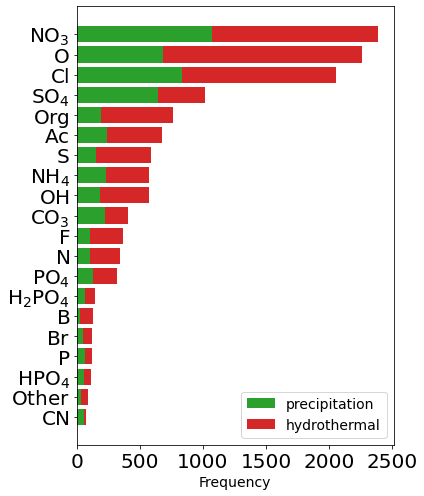

In [72]:
to_plot_hyd = {x: len(hyd_anion_dict[x]) for x in hyd_anion_dict}
to_plot_prec = {x: len(prec_anion_dict[x]) for x in prec_anion_dict}
to_plot_hyd = {k: v for k, v in sorted(to_plot_hyd.items(), key=lambda item: item[1])}
to_plot_prec = {k: v for k, v in sorted(to_plot_prec.items(), key=lambda item: item[1])}

sol_top_anions = list(to_plot_sol.keys())[-20:]
to_plot_hyd_2 = [to_plot_hyd[x] for x in sol_top_anions]
to_plot_prec_2 = [to_plot_prec[x] for x in sol_top_anions]

fig, ax = plt.subplots(1, 1, figsize=(6, 7))
ax.barh(y=clean_formulas(sol_top_anions), width=to_plot_prec_2, height=0.8, color="C2", label="precipitation")
ax.barh(y=clean_formulas(sol_top_anions), width=to_plot_hyd_2, height=0.8, color="C3", left=to_plot_prec_2, label="hydrothermal")

ax.set_xlabel("Frequency", fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=14)

fig.tight_layout()
plt.show()

# fig.savefig('figures/top_sol_anions.png', dpi=150)

In [74]:
# plot all three together as fractions of total # precursors
# all_to_plot_keys = list(set(list(to_plot_ss.keys()) + list(to_plot_sg.keys()) + list(to_plot_sol.keys())))
all_to_plot_keys = list(set(list(to_plot_ss.keys()) + list(to_plot_sg.keys()) + list(to_plot_hyd.keys()) + list(to_plot_prec.keys())))

In [75]:
# ss_stacked, sg_stacked, sol_stacked = [], [], []
# total_sum = []
# for key in all_to_plot_keys:
#     ss_stacked.append(to_plot_ss.get(key, 0) / len(ss_precs_all))
#     sg_stacked.append(to_plot_sg.get(key, 0) / len(sg_precs_all))
#     sol_stacked.append(to_plot_sol.get(key, 0) / len(sol_precs_all))
#     total_sum.append(to_plot_ss.get(key, 0) / len(ss_precs_all) + to_plot_sg.get(key, 0) / len(sg_precs_all) + to_plot_sol.get(key, 0) / len(sol_precs_all))
# ss_stacked, sg_stacked, sol_stacked = np.array(ss_stacked), np.array(sg_stacked), np.array(sol_stacked)
# all_to_plot_keys = np.array(all_to_plot_keys)

ss_stacked, sg_stacked, hyd_stacked, prec_stacked = [], [], [], []
total_sum = []
for key in all_to_plot_keys:
    ss_stacked.append(to_plot_ss.get(key, 0) / len(ss_precs_all))
    sg_stacked.append(to_plot_sg.get(key, 0) / len(sg_precs_all))
    hyd_stacked.append(to_plot_hyd.get(key, 0) / len(hyd_precs_all))
    prec_stacked.append(to_plot_prec.get(key, 0) / len(prec_precs_all))
    total_sum.append(to_plot_ss.get(key, 0) / len(ss_precs_all) + to_plot_sg.get(key, 0) / len(sg_precs_all) + to_plot_hyd.get(key, 0) / len(hyd_precs_all) + to_plot_prec.get(key, 0) / len(prec_precs_all))
ss_stacked, sg_stacked, hyd_stacked, prec_stacked = np.array(ss_stacked), np.array(sg_stacked), np.array(hyd_stacked), np.array(prec_stacked)
all_to_plot_keys = np.array(all_to_plot_keys)

In [76]:
# sorted_inds = np.argsort(total_sum)
# ss_stacked = ss_stacked[sorted_inds]
# sg_stacked = sg_stacked[sorted_inds]
# sol_stacked = sol_stacked[sorted_inds]
# all_to_plot_keys = all_to_plot_keys[sorted_inds]

sorted_inds = np.argsort(total_sum)[::-1]
ss_stacked = ss_stacked[sorted_inds]
sg_stacked = sg_stacked[sorted_inds]
hyd_stacked = hyd_stacked[sorted_inds]
prec_stacked = prec_stacked[sorted_inds]
all_to_plot_keys = clean_formulas(all_to_plot_keys[sorted_inds])

In [77]:
# fig, ax = plt.subplots(figsize=(6, 10))

# ax.barh(all_to_plot_keys, ss_stacked, label="solid-state")
# ax.barh(all_to_plot_keys, sg_stacked, left = ss_stacked, label="sol-gel")
# ax.barh(all_to_plot_keys, prec_stacked, left = ss_stacked + sg_stacked, label="precipitation")
# ax.barh(all_to_plot_keys, hyd_stacked, left = ss_stacked + sg_stacked + prec_stacked, label="hydrothermal")
# ax.legend(loc="lower right", fontsize=14)

# ax.set_xlabel("Fraction of reported precursors", fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# fig.tight_layout()
# plt.show()

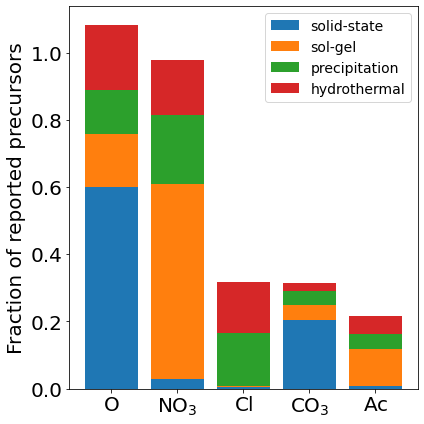

In [78]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.bar(all_to_plot_keys[:5], ss_stacked[:5], label="solid-state")
ax.bar(all_to_plot_keys[:5], sg_stacked[:5], bottom = ss_stacked[:5], label="sol-gel")
ax.bar(all_to_plot_keys[:5], prec_stacked[:5], bottom = ss_stacked[:5] + sg_stacked[:5], label="precipitation")
ax.bar(all_to_plot_keys[:5], hyd_stacked[:5], bottom = ss_stacked[:5] + sg_stacked[:5] + prec_stacked[:5], label="hydrothermal")
ax.legend(fontsize=14)

ax.set_ylabel("Fraction of reported precursors", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fig.tight_layout()
plt.show()

# fig.savefig('figures/top_compare_anions_1.png', dpi=150)

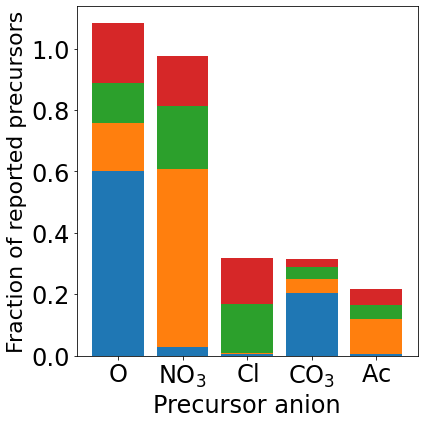

In [124]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.bar(all_to_plot_keys[:5], ss_stacked[:5], label="solid-state")
ax.bar(all_to_plot_keys[:5], sg_stacked[:5], bottom = ss_stacked[:5], label="sol-gel")
ax.bar(all_to_plot_keys[:5], prec_stacked[:5], bottom = ss_stacked[:5] + sg_stacked[:5], label="precipitation")
ax.bar(all_to_plot_keys[:5], hyd_stacked[:5], bottom = ss_stacked[:5] + sg_stacked[:5] + prec_stacked[:5], label="hydrothermal")
# ax.legend(fontsize=14)

ax.set_xlabel("Precursor anion", fontsize=24)
ax.set_ylabel("Fraction of reported precursors", fontsize=22)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

fig.tight_layout()
plt.show()

fig.savefig('figures/top_compare_anions_1_v2.png', dpi=150)

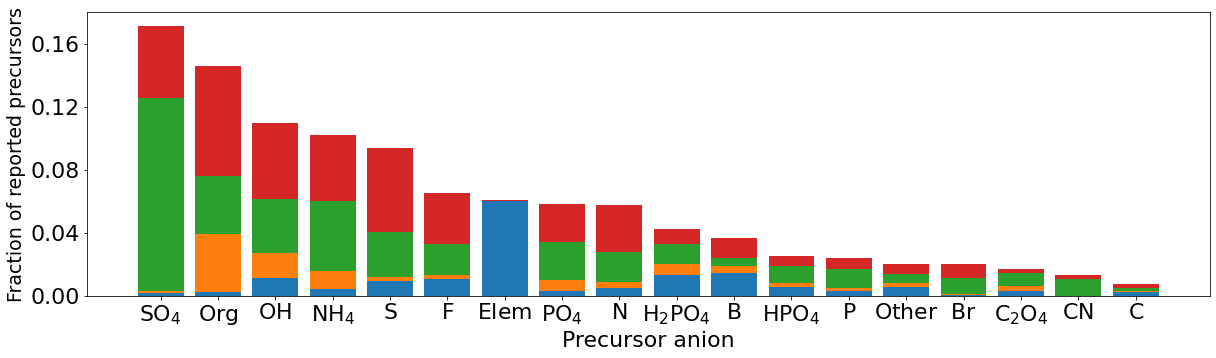

In [167]:
fig, ax = plt.subplots(figsize=(17, 5))

ax.bar(all_to_plot_keys[5:23], ss_stacked[5:23], label="solid-state")
ax.bar(all_to_plot_keys[5:23], sg_stacked[5:23], bottom = ss_stacked[5:23], label="sol-gel")
ax.bar(all_to_plot_keys[5:23], prec_stacked[5:23], bottom = ss_stacked[5:23] + sg_stacked[5:23], label="precipitation")
ax.bar(all_to_plot_keys[5:23], hyd_stacked[5:23], bottom = ss_stacked[5:23] + sg_stacked[5:23] + prec_stacked[5:23], label="hydrothermal")
# ax.legend(fontsize=14)

ax.set_xlabel("Precursor anion", fontsize=22)
ax.set_ylabel("Fraction of reported precursors", fontsize=19)
ax.set_yticks([0, 0.04, 0.08, 0.12, 0.16])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

fig.tight_layout()
plt.show()

fig.savefig('figures/top_compare_anions_2_v2.png', dpi=150)

# Target visualization

In [159]:
ss_target_element_frequency, sg_target_element_frequency, prec_target_element_frequency, hyd_target_element_frequency = {}, {}, {}, {}
for paper in only_ss_rxns:
    target = paper['target']
    target_comp = Composition(target)
    for element in [x.symbol for x in target_comp.elements]:
        if element not in ss_target_element_frequency.keys():
            ss_target_element_frequency[element] = 1
        else:
            ss_target_element_frequency[element] += 1
for paper in only_sg_rxns:
    target = paper['target']
    target_comp = Composition(target)
    for element in [x.symbol for x in target_comp.elements]:
        if element not in sg_target_element_frequency.keys():
            sg_target_element_frequency[element] = 1
        else:
            sg_target_element_frequency[element] += 1
for paper in only_prec_rxns:
    target = paper['target']
    target_comp = Composition(target)
    for element in [x.symbol for x in target_comp.elements]:
        if element not in prec_target_element_frequency.keys():
            prec_target_element_frequency[element] = 1
        else:
            prec_target_element_frequency[element] += 1
for paper in only_hyd_rxns:
    target = paper['target']
    target_comp = Composition(target)
    for element in [x.symbol for x in target_comp.elements]:
        if element not in hyd_target_element_frequency.keys():
            hyd_target_element_frequency[element] = 1
        else:
            hyd_target_element_frequency[element] += 1

In [160]:
all_target_shared_elems = list(set(list(ss_target_element_frequency) + list(sg_target_element_frequency) + list(prec_target_element_frequency) + list(prec_target_element_frequency)))
all_target_shared_elems.remove("O")
ss_tar_els, sg_tar_els, prec_tar_els, hyd_tar_els = [], [], [], []
total_els = []

for key in all_target_shared_elems:
    ss_tar_els.append(ss_target_element_frequency.get(key, 0) / len(only_ss_rxns))
    sg_tar_els.append(sg_target_element_frequency.get(key, 0) / len(only_sg_rxns))
    prec_tar_els.append(prec_target_element_frequency.get(key, 0) / len(only_prec_rxns))
    hyd_tar_els.append(hyd_target_element_frequency.get(key, 0) / len(only_hyd_rxns))
    total_els.append(ss_target_element_frequency.get(key, 0) / len(only_ss_rxns) + sg_target_element_frequency.get(key, 0) / len(only_sg_rxns) + prec_target_element_frequency.get(key, 0) / len(only_prec_rxns) + hyd_target_element_frequency.get(key, 0) / len(only_hyd_rxns))
ss_tar_els, sg_tar_els, prec_tar_els, hyd_tar_els = np.array(ss_tar_els), np.array(sg_tar_els), np.array(prec_tar_els), np.array(hyd_tar_els)
all_target_shared_elems = np.array(all_target_shared_elems)


In [161]:
sorted_inds_tar = np.argsort(total_els)[::-1]
sorted_inds_tar = sorted_inds_tar[:30]
ss_tar_els = ss_tar_els[sorted_inds_tar]
sg_tar_els = sg_tar_els[sorted_inds_tar]
prec_tar_els = prec_tar_els[sorted_inds_tar]
hyd_tar_els = hyd_tar_els[sorted_inds_tar]
all_target_shared_elems = all_target_shared_elems[sorted_inds_tar]

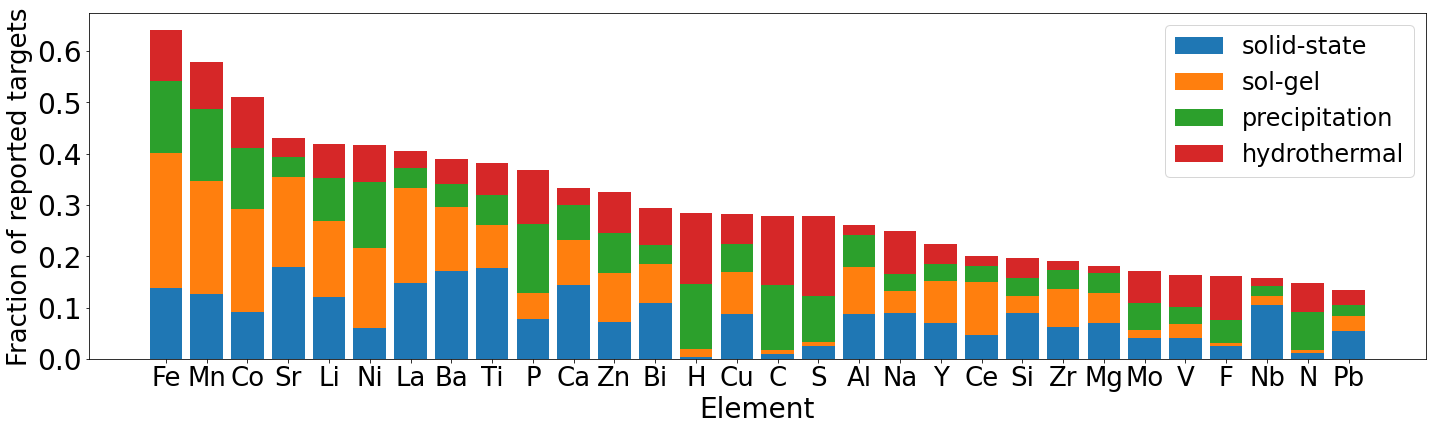

In [162]:
# elements [0, 27)
fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(all_target_shared_elems, ss_tar_els, label="solid-state")
ax.bar(all_target_shared_elems, sg_tar_els, bottom = ss_tar_els, label="sol-gel")
ax.bar(all_target_shared_elems, prec_tar_els, bottom = ss_tar_els + sg_tar_els, label="precipitation")
ax.bar(all_target_shared_elems, hyd_tar_els, bottom = ss_tar_els + sg_tar_els + prec_tar_els, label="hydrothermal")
ax.legend(fontsize=24)

ax.set_xlabel("Element", fontsize=28)
ax.set_ylabel("Fraction of reported targets", fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=28)

fig.tight_layout()
plt.show()

fig.savefig('figures/top_compare_els_1_v2.png', dpi=150)

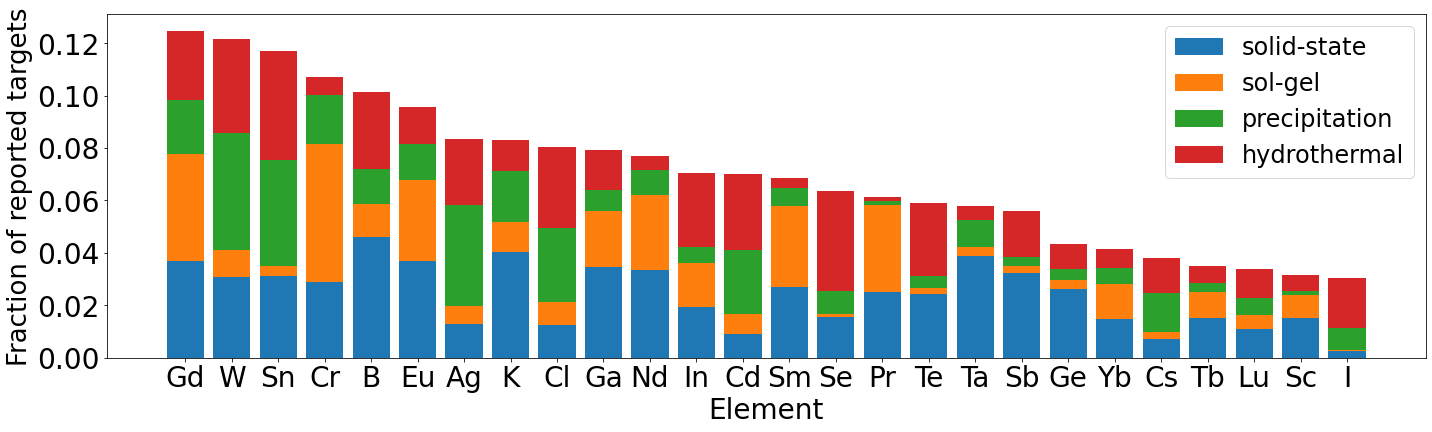

In [156]:
# elements [40, 82)
all_target_shared_elems = list(set(list(ss_target_element_frequency) + list(sg_target_element_frequency) + list(prec_target_element_frequency) + list(prec_target_element_frequency)))
all_target_shared_elems.remove("O")
ss_tar_els, sg_tar_els, prec_tar_els, hyd_tar_els = [], [], [], []
total_els = []

for key in all_target_shared_elems:
    ss_tar_els.append(ss_target_element_frequency.get(key, 0) / len(only_ss_rxns))
    sg_tar_els.append(sg_target_element_frequency.get(key, 0) / len(only_sg_rxns))
    prec_tar_els.append(prec_target_element_frequency.get(key, 0) / len(only_prec_rxns))
    hyd_tar_els.append(hyd_target_element_frequency.get(key, 0) / len(only_hyd_rxns))
    total_els.append(ss_target_element_frequency.get(key, 0) / len(only_ss_rxns) + sg_target_element_frequency.get(key, 0) / len(only_sg_rxns) + prec_target_element_frequency.get(key, 0) / len(only_prec_rxns) + hyd_target_element_frequency.get(key, 0) / len(only_hyd_rxns))
ss_tar_els, sg_tar_els, prec_tar_els, hyd_tar_els = np.array(ss_tar_els), np.array(sg_tar_els), np.array(prec_tar_els), np.array(hyd_tar_els)
all_target_shared_elems = np.array(all_target_shared_elems)

sorted_inds_tar = np.argsort(total_els)[::-1]
sorted_inds_tar = sorted_inds_tar[30:56]
ss_tar_els = ss_tar_els[sorted_inds_tar]
sg_tar_els = sg_tar_els[sorted_inds_tar]
prec_tar_els = prec_tar_els[sorted_inds_tar]
hyd_tar_els = hyd_tar_els[sorted_inds_tar]
all_target_shared_elems = all_target_shared_elems[sorted_inds_tar]

fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(all_target_shared_elems, ss_tar_els, label="solid-state")
ax.bar(all_target_shared_elems, sg_tar_els, bottom = ss_tar_els, label="sol-gel")
ax.bar(all_target_shared_elems, prec_tar_els, bottom = ss_tar_els + sg_tar_els, label="precipitation")
ax.bar(all_target_shared_elems, hyd_tar_els, bottom = ss_tar_els + sg_tar_els + prec_tar_els, label="hydrothermal")
ax.legend(fontsize=24)

ax.set_xlabel("Element", fontsize=28)
ax.set_ylabel("Fraction of reported targets", fontsize=26)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

fig.tight_layout()
plt.show()

fig.savefig('figures/top_compare_els_2_v2.png', dpi=150)

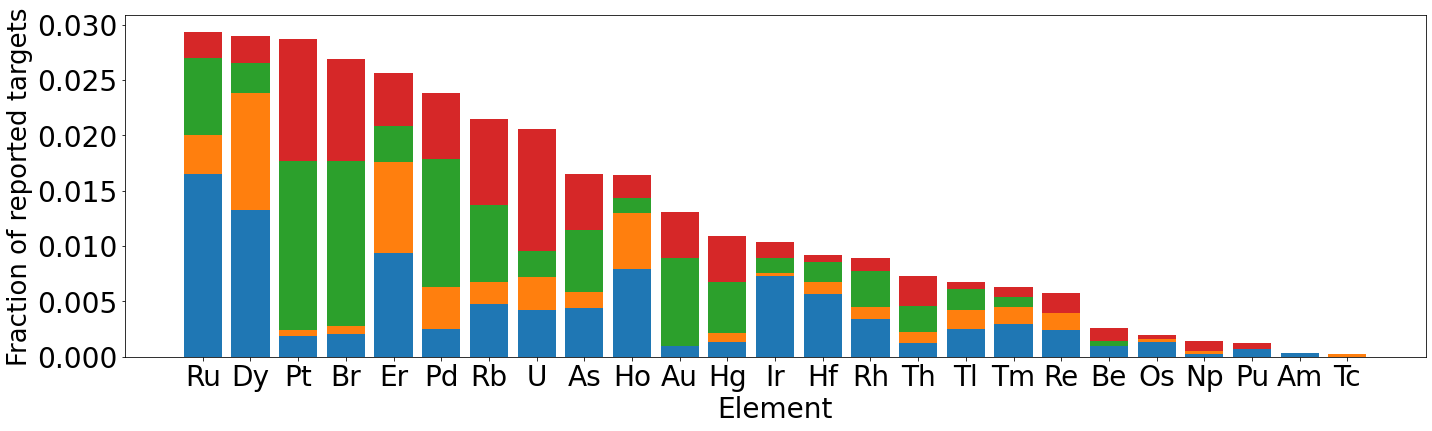

In [158]:
# elements [40, 82)
all_target_shared_elems = list(set(list(ss_target_element_frequency) + list(sg_target_element_frequency) + list(prec_target_element_frequency) + list(prec_target_element_frequency)))
all_target_shared_elems.remove("O")
ss_tar_els, sg_tar_els, prec_tar_els, hyd_tar_els = [], [], [], []
total_els = []

for key in all_target_shared_elems:
    ss_tar_els.append(ss_target_element_frequency.get(key, 0) / len(only_ss_rxns))
    sg_tar_els.append(sg_target_element_frequency.get(key, 0) / len(only_sg_rxns))
    prec_tar_els.append(prec_target_element_frequency.get(key, 0) / len(only_prec_rxns))
    hyd_tar_els.append(hyd_target_element_frequency.get(key, 0) / len(only_hyd_rxns))
    total_els.append(ss_target_element_frequency.get(key, 0) / len(only_ss_rxns) + sg_target_element_frequency.get(key, 0) / len(only_sg_rxns) + prec_target_element_frequency.get(key, 0) / len(only_prec_rxns) + hyd_target_element_frequency.get(key, 0) / len(only_hyd_rxns))
ss_tar_els, sg_tar_els, prec_tar_els, hyd_tar_els = np.array(ss_tar_els), np.array(sg_tar_els), np.array(prec_tar_els), np.array(hyd_tar_els)
all_target_shared_elems = np.array(all_target_shared_elems)

sorted_inds_tar = np.argsort(total_els)[::-1]
sorted_inds_tar = sorted_inds_tar[56:]
ss_tar_els = ss_tar_els[sorted_inds_tar]
sg_tar_els = sg_tar_els[sorted_inds_tar]
prec_tar_els = prec_tar_els[sorted_inds_tar]
hyd_tar_els = hyd_tar_els[sorted_inds_tar]
all_target_shared_elems = all_target_shared_elems[sorted_inds_tar]

fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(all_target_shared_elems, ss_tar_els, label="solid-state")
ax.bar(all_target_shared_elems, sg_tar_els, bottom = ss_tar_els, label="sol-gel")
ax.bar(all_target_shared_elems, prec_tar_els, bottom = ss_tar_els + sg_tar_els, label="precipitation")
ax.bar(all_target_shared_elems, hyd_tar_els, bottom = ss_tar_els + sg_tar_els + prec_tar_els, label="hydrothermal")
# ax.legend(fontsize=24)

ax.set_xlabel("Element", fontsize=28)
ax.set_ylabel("Fraction of reported targets", fontsize=26)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

fig.tight_layout()
plt.show()

fig.savefig('figures/top_compare_els_3_v2.png', dpi=150)

# Precursor MP graph

In [18]:
with open('data/full_mp.json', 'r') as f:
    full_mp = json.load(f)

In [19]:
full_mp = {Composition(x): full_mp[x] for x in full_mp}

In [20]:
full_mp_median = np.median(list(full_mp.values()))

In [ ]:
# check how many unique precursors have MPs tabulated
ss_contained, ss_not_contained = [], []
sg_contained, sg_not_contained = [], []
prec_contained, prec_not_contained = [], []
hyd_contained, hyd_not_contained  = [], []
for prec in set(ss_precs_all):
    if Composition(prec) in full_mp:
        ss_contained.append(prec)
    else:
        ss_not_contained.append(prec)
for prec in set(sg_precs_all):
    if Composition(prec) in full_mp:
        sg_contained.append(prec)
    else:
        sg_not_contained.append(prec)
for prec in set(prec_precs_all):
    if Composition(prec) in full_mp:
        prec_contained.append(prec)
    else:
        prec_not_contained.append(prec)
for prec in set(hyd_precs_all):
    if Composition(prec) in full_mp:
        hyd_contained.append(prec)
    else:
        hyd_not_contained.append(prec)

In [ ]:
print(len(ss_contained) / (len(ss_contained) + len(ss_not_contained)))
print(len(sg_contained) / (len(sg_contained) + len(sg_not_contained)))
print(len(prec_contained) / (len(prec_contained) + len(prec_not_contained)))
print(len(hyd_contained) / (len(hyd_contained) + len(hyd_not_contained)))

In [ ]:
# check how many non-unique precursors have MPs tabulated
ss_contained, ss_not_contained = [], []
sg_contained, sg_not_contained = [], []
prec_contained, prec_not_contained = [], []
hyd_contained, hyd_not_contained = [], []
for prec in ss_precs_all:
    if Composition(prec) in full_mp:
        ss_contained.append(prec)
    else:
        ss_not_contained.append(prec)
for prec in sg_precs_all:
    if Composition(prec) in full_mp:
        sg_contained.append(prec)
    else:
        sg_not_contained.append(prec)
for prec in prec_precs_all:
    if Composition(prec) in full_mp:
        prec_contained.append(prec)
    else:
        prec_not_contained.append(prec)
        

In [ ]:
# check how many non-unique precursors have MPs tabulated
ss_contained, ss_not_contained = [], []
sg_contained, sg_not_contained = [], []
sol_contained, sol_not_contained = [], []
for prec in ss_precs_all:
    if Composition(prec) in full_mp:
        ss_contained.append(prec)
    else:
        ss_not_contained.append(prec)
for prec in sg_precs_all:
    if Composition(prec) in full_mp:
        sg_contained.append(prec)
    else:
        sg_not_contained.append(prec)
for prec in sol_precs_all:
    if Composition(prec) in full_mp:
        sol_contained.append(prec)
    else:
        sol_not_contained.append(prec)

In [ ]:
print(len(ss_contained) / (len(ss_contained) + len(ss_not_contained)))
print(len(sg_contained) / (len(sg_contained) + len(sg_not_contained)))
print(len(sol_contained) / (len(sol_contained) + len(sol_not_contained)))

In [ ]:
ss_mp_precs = [x for x in list(ss_precs_all) if Composition(x) in full_mp]
ss_mp = [full_mp[Composition(x)] for x in ss_mp_precs]
sg_mp_precs = [x for x in list(sg_precs_all) if Composition(x) in full_mp]
sg_mp = [full_mp[Composition(x)] for x in sg_mp_precs]
prec_mp_precs = [x for x in list(prec_precs_all) if Composition(x) in full_mp]
prec_mp = [full_mp[Composition(x)] for x in prec_mp_precs]
hyd_mp_precs = [x for x in list(hyd_precs_all) if Composition(x) in full_mp]
hyd_mp = [full_mp[Composition(x)] for x in hyd_mp_precs]

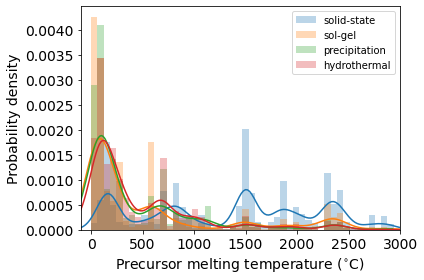

In [362]:
fig, ax = plt.subplots()
bins = np.linspace(0, 3000, num=50)
sns.histplot(ss_mp, color="C0", label="solid-state", kde=True, stat="density", linewidth=0, bins=bins, alpha=0.3)
sns.histplot(sg_mp, color="C1", label="sol-gel", kde=True, stat="density", linewidth=0, bins=bins, alpha=0.3)
sns.histplot(prec_mp, color="C2", label="precipitation", kde=True, stat="density", linewidth=0, bins=bins, alpha=0.3)
sns.histplot(hyd_mp, color="C3", label="hydrothermal", kde=True, stat="density", linewidth=0, bins=bins, alpha=0.3)


ax.set_xlim(-100, 3000)

ax.set_xlabel("Precursor melting temperature ($^{\circ}$C)", fontsize=14)
ax.set_ylabel("Probability density", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.legend()

fig.tight_layout()
plt.show()

fig.savefig('figures/compare_mp.png', dpi=150)

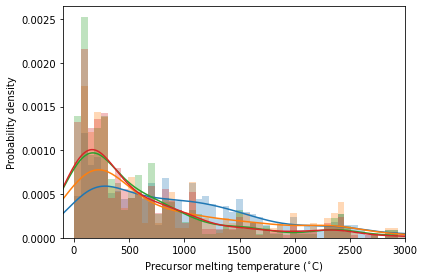

In [375]:
# unique precursor MP distributions
ss_mp_set = [full_mp[Composition(x)] for x in set(ss_mp_precs)]
sg_mp_set = [full_mp[Composition(x)] for x in set(sg_mp_precs)]
prec_mp_set = [full_mp[Composition(x)] for x in set(prec_mp_precs)]
hyd_mp_set = [full_mp[Composition(x)] for x in set(hyd_mp_precs)]

fig, ax = plt.subplots()
bins = np.linspace(0, 3000)
sns.histplot(ss_mp_set, color="C0", label="solid-state", kde=True, stat="density", linewidth=0, bins=bins, alpha=0.3)
sns.histplot(sg_mp_set, color="C1", label="sol-gel", kde=True, stat="density", linewidth=0, bins=bins, alpha=0.3)
sns.histplot(prec_mp_set, color="C2", label="precipitation", kde=True, stat="density", linewidth=0, bins=bins, alpha=0.3)
sns.histplot(hyd_mp_set, color="C3", label="hydrothermal", kde=True, stat="density", linewidth=0, bins=bins, alpha=0.3)


ax.set_xlim(-100, 3000)

ax.set_xlabel("Precursor melting temperature ($^{\circ}$C)")
ax.set_ylabel("Probability density")
fig.tight_layout()
plt.show()

# fig.savefig('figures/compare_mp.png', dpi=150)

In [27]:
# add MP features
for new_result in only_ss_rxns:
    # precursor MP features
    melting_points = [full_mp.get(Composition(x), full_mp_median) for x in new_result["precursors"]]
    new_result['feature_exp_min_mp'] = min(melting_points)
    new_result['feature_exp_max_mp'] = max(melting_points)
    new_result['feature_exp_mean_mp'] = np.mean(melting_points)
    new_result['feature_exp_div_mp'] = max(melting_points) - min(melting_points)
for new_result in only_sg_rxns:
    # precursor MP features
    melting_points = [full_mp.get(Composition(x), full_mp_median) for x in new_result["precursors"]]
    new_result['feature_exp_min_mp'] = min(melting_points)
    new_result['feature_exp_max_mp'] = max(melting_points)
    new_result['feature_exp_mean_mp'] = np.mean(melting_points)
    new_result['feature_exp_div_mp'] = max(melting_points) - min(melting_points)
for new_result in only_prec_rxns:
    # precursor MP features
    melting_points = [full_mp.get(Composition(x), full_mp_median) for x in new_result["precursors"]]
    new_result['feature_exp_min_mp'] = min(melting_points)
    new_result['feature_exp_max_mp'] = max(melting_points)
    new_result['feature_exp_mean_mp'] = np.mean(melting_points)
    new_result['feature_exp_div_mp'] = max(melting_points) - min(melting_points)
for new_result in only_hyd_rxns:
    # precursor MP features
    melting_points = [full_mp.get(Composition(x), full_mp_median) for x in new_result["precursors"]]
    new_result['feature_exp_min_mp'] = min(melting_points)
    new_result['feature_exp_max_mp'] = max(melting_points)
    new_result['feature_exp_mean_mp'] = np.mean(melting_points)
    new_result['feature_exp_div_mp'] = max(melting_points) - min(melting_points)

In [28]:
target_names = [x["target"] for x in only_ss_rxns] + [x["target"] for x in only_sg_rxns] + [x["target"] for x in only_hyd_rxns] + [x["target"] for x in only_prec_rxns]
labels = np.concatenate([np.ones(shape=len(only_ss_rxns)), np.zeros(shape=len(only_sg_rxns)), np.full(shape=len(only_hyd_rxns) + len(only_prec_rxns), fill_value=2)])
labels_multiclass = np.concatenate([np.ones(shape=len(only_ss_rxns)), np.zeros(shape=len(only_sg_rxns)), np.full(shape=len(only_hyd_rxns), fill_value=2), np.full(shape=len(only_prec_rxns), fill_value=3)])
precursors = [x["precursors"] for x in only_ss_rxns] + [x["precursors"] for x in only_sg_rxns] + [x["precursors"] for x in only_hyd_rxns] + [x["precursors"] for x in only_prec_rxns]
feature_exp_min_mp = [x['feature_exp_min_mp'] for x in only_ss_rxns] + [x['feature_exp_min_mp'] for x in only_sg_rxns] + [x['feature_exp_min_mp'] for x in only_hyd_rxns] + [x['feature_exp_min_mp'] for x in only_prec_rxns]
feature_exp_max_mp = [x['feature_exp_max_mp'] for x in only_ss_rxns] + [x['feature_exp_max_mp'] for x in only_sg_rxns] + [x['feature_exp_max_mp'] for x in only_hyd_rxns] + [x['feature_exp_max_mp'] for x in only_prec_rxns]
feature_exp_mean_mp = [x['feature_exp_mean_mp'] for x in only_ss_rxns] + [x['feature_exp_mean_mp'] for x in only_sg_rxns] + [x['feature_exp_mean_mp'] for x in only_hyd_rxns] + [x['feature_exp_mean_mp'] for x in only_prec_rxns] 
feature_exp_div_mp = [x['feature_exp_div_mp'] for x in only_ss_rxns] + [x['feature_exp_div_mp'] for x in only_sg_rxns] + [x['feature_exp_div_mp'] for x in only_hyd_rxns] + [x['feature_exp_div_mp'] for x in only_prec_rxns]

In [29]:
feature_calculators = MultipleFeaturizer([
    cf.ElementFraction()
])

In [30]:
# Onehot precursor functional groups
m_anions = ['H2PO4', 'HPO4', 'HCO3', 'HSO4', 'HSO3', 'C2O4']
d_anions = ['CO3', 'PO4', 'PO3', 'OH', 'NH4', 'NO3', 'NO2', 'SO4', 'SO3', 'CN'] #BO3, VO4, NH2
s_anions = ['N', 'F', 'S', 'B', 'P', 'Cl', 'F', 'Br', 'O', 'C']
ions = m_anions + d_anions + s_anions + ['Org'] + ['Ac'] + ['Elem'] + ['Other']

In [31]:
ss_anion_dict = {x: [] for x in ions}
for rxn in only_ss_rxns:
    anion_dict = {x: [] for x in ions}
    for prec in rxn['precursors']:
        found = False
        # check acetate first
        if 'CH3COO' in prec:
            anion_dict['Ac'].append(prec)
            found = True
        # check organic
        elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
            anion_dict['Org'].append(prec)
            found = True
        else:
            for anion in ions:
                # special check for elemental anions
                if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                    anion_dict[anion].append(prec)
                    found = True
                    break
        if not found:
            # check if precursor is elemental
            if prec in all_elements:
                anion_dict['Elem'].append(prec)
            else:
                anion_dict['Other'].append(prec)
    # create fractional embedding
    for key in anion_dict:
        ss_anion_dict[key].append(len(anion_dict[key]) / len(rxn['precursors']))
        

In [32]:
sg_anion_dict = {x: [] for x in ions}
for rxn in only_sg_rxns:
    anion_dict = {x: [] for x in ions}
    for prec in rxn['precursors']:
        found = False
        # check acetate first
        if 'CH3COO' in prec:
            anion_dict['Ac'].append(prec)
            found = True
        # check organic
        elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
            anion_dict['Org'].append(prec)
            found = True
        else:
            for anion in ions:
                # special check for elemental anions
                if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                    anion_dict[anion].append(prec)
                    found = True
                    break
        if not found:
            # check if precursor is elemental
            if prec in all_elements:
                anion_dict['Elem'].append(prec)
            else:
                anion_dict['Other'].append(prec)
    # create fractional embedding
    for key in anion_dict:
        sg_anion_dict[key].append(len(anion_dict[key]) / len(rxn['precursors']))
        

In [33]:
hyd_anion_dict = {x: [] for x in ions}
for rxn in only_hyd_rxns:
    anion_dict = {x: [] for x in ions}
    for prec in rxn['precursors']:
        found = False
        # check acetate first
        if 'CH3COO' in prec:
            anion_dict['Ac'].append(prec)
            found = True
        # check organic
        elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
            anion_dict['Org'].append(prec)
            found = True
        else:
            for anion in ions:
                # special check for elemental anions
                if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                    anion_dict[anion].append(prec)
                    found = True
                    break
        if not found:
            # check if precursor is elemental
            if prec in all_elements:
                anion_dict['Elem'].append(prec)
            else:
                anion_dict['Other'].append(prec)
    # create fractional embedding
    for key in anion_dict:
        hyd_anion_dict[key].append(len(anion_dict[key]) / len(rxn['precursors']))
        

In [34]:
prec_anion_dict = {x: [] for x in ions}
for rxn in only_prec_rxns:
    anion_dict = {x: [] for x in ions}
    for prec in rxn['precursors']:
        found = False
        # check acetate first
        if 'CH3COO' in prec:
            anion_dict['Ac'].append(prec)
            found = True
        # check organic
        elif all(Element(x) in Composition(prec).elements for x in ['C', 'H', 'O']) and Element('N') not in Composition(prec).elements:
            anion_dict['Org'].append(prec)
            found = True
        else:
            for anion in ions:
                # special check for elemental anions
                if (anion in all_elements and Element(anion) in Composition(prec).elements) or (anion not in all_elements and anion in prec):
                    anion_dict[anion].append(prec)
                    found = True
                    break
        if not found:
            # check if precursor is elemental
            if prec in all_elements:
                anion_dict['Elem'].append(prec)
            else:
                anion_dict['Other'].append(prec)
    # create fractional embedding
    for key in anion_dict:
        prec_anion_dict[key].append(len(anion_dict[key]) / len(rxn['precursors']))
        

In [35]:
print(len(ss_anion_dict['O']), len(sg_anion_dict['O']), len(hyd_anion_dict['O']), len(prec_anion_dict['O']))

15937 3979 3362 2150


In [36]:
data = pd.DataFrame()
data["targets"] = target_names
data["precursors"] = precursors
data["labels"] = labels
data["labels_multiclass"] = labels_multiclass
df = StrToComposition(target_col_id="composition_obj").featurize_dataframe(data, "targets", ignore_errors=True)
df = feature_calculators.featurize_dataframe(df, col_id="composition_obj", ignore_errors = True)

for key in ss_anion_dict:
    df[key + "_prec"] = ss_anion_dict[key] + sg_anion_dict[key] + hyd_anion_dict[key] + prec_anion_dict[key]

In [37]:
df['feature_exp_min_mp'] = feature_exp_min_mp
df['feature_exp_max_mp'] = feature_exp_max_mp
df['feature_exp_mean_mp'] = feature_exp_mean_mp
df['feature_exp_div_mp'] = feature_exp_div_mp

In [38]:
df

,targets,precursors,labels,labels_multiclass,composition_obj,H,He,Li,Be,B,...,O_prec,C_prec,Org_prec,Ac_prec,Elem_prec,Other_prec,feature_exp_min_mp,feature_exp_max_mp,feature_exp_mean_mp,feature_exp_div_mp
0,Nb9PO25,"[Nb2O5, PH6NO4]",1.0,1.0,"(Nb, P, O)",0.000000,0,0.000000,0.0,0.0,...,0.500000,0.0,0.000000,0.0,0.0,0.0,190.00,1520.0,855.000000,1330.00
1,Li1Mn1.7Fe0.3O4,"[FeHO2, LiHO, MnCO3]",1.0,1.0,"(Li, Mn, Fe, O)",0.000000,0,0.142857,0.0,0.0,...,0.666667,0.0,0.000000,0.0,0.0,0.0,179.00,680.0,353.000000,501.00
2,Li1Ti0.05Ni0.95O2,"[LiHO, Ni(HO)2, TiO2]",1.0,1.0,"(Li, Ti, Ni, O)",0.000000,0,0.250000,0.0,0.0,...,1.000000,0.0,0.000000,0.0,0.0,0.0,230.00,1855.0,921.666667,1625.00
3,NdCoO3,"[Co3O4, Nd2O3]",1.0,1.0,"(Nd, Co, O)",0.000000,0,0.000000,0.0,0.0,...,1.000000,0.0,0.000000,0.0,0.0,0.0,947.00,2272.0,1609.500000,1325.00
4,Sr0.4Pr0.6Co1O3,"[Co2O3, Pr6O11, SrCO3]",1.0,1.0,"(Sr, Pr, Co, O)",0.000000,0,0.000000,0.0,0.0,...,0.666667,0.0,0.000000,0.0,0.0,0.0,150.00,2183.0,1276.666667,2033.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25423,BiClO,"[BiCl3, HCl]",2.0,3.0,"(Bi, Cl, O)",0.000000,0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,-114.22,230.0,57.890000,344.22
25424,Y3Al5O12,"[Al(NO3)3, Y2O3]",2.0,3.0,"(Y, Al, O)",0.000000,0,0.000000,0.0,0.0,...,0.500000,0.0,0.000000,0.0,0.0,0.0,73.00,2439.0,1256.000000,2366.00
25425,LiLa(PO3)4,"[La2O3, Li2CO3, PH9(NO2)2]",2.0,3.0,"(Li, La, P, O)",0.000000,0,0.055556,0.0,0.0,...,0.333333,0.0,0.000000,0.0,0.0,0.0,155.00,2315.0,1065.333333,2160.00
25426,Ca5P3HO13,"[CaO, PH3O4]",2.0,3.0,"(Ca, P, H, O)",0.045455,0,0.000000,0.0,0.0,...,0.500000,0.0,0.000000,0.0,0.0,0.0,89.00,2927.0,1508.000000,2838.00


In [39]:
omit_columns = ['targets', 'precursors', 'labels', 'labels_multiclass', 'composition_obj']
X_columns = [x for x in df.columns if x not in omit_columns]
y_column = 'labels_multiclass'
X_df = df[X_columns]
X = X_df.values
y = df[y_column].values
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (25428, 136)
Shape of y: (25428,)


# RXN visualization, target + precursor MP + fractional

In [40]:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)

In [41]:
X_rxn_TSNE = TSNE(n_components=2, init='random').fit_transform(X_transformed)

In [42]:
sg_tsne = []
ss_tsne = []
hyd_tsne = []
prec_tsne = []
for i in range(X_rxn_TSNE.shape[0]):
    if y[i] == 0:
        # sg
        sg_tsne.append(X_rxn_TSNE[i])
    elif y[i] == 1:
        # ss
        ss_tsne.append(X_rxn_TSNE[i])
    elif y[i] == 2:
        hyd_tsne.append(X_rxn_TSNE[i])
    else:
        # sol (2 = hydrothermal, 3 = precipitation)
        prec_tsne.append(X_rxn_TSNE[i])
ss_tsne = np.array(ss_tsne)
sg_tsne = np.array(sg_tsne)
hyd_tsne = np.array(hyd_tsne)
prec_tsne = np.array(prec_tsne)

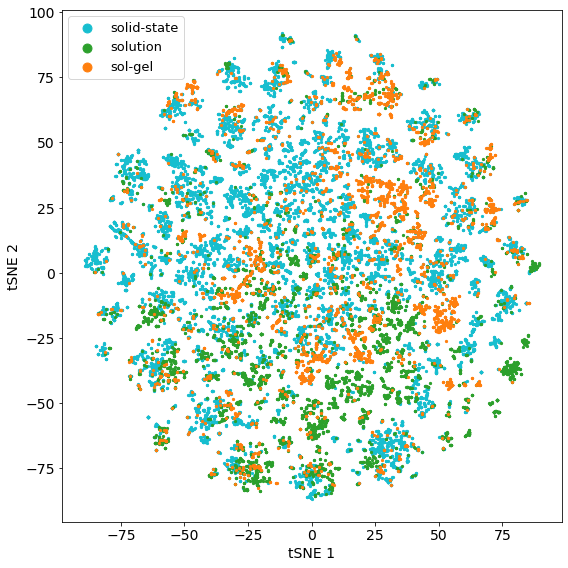

In [83]:
fig, ax = plt.subplots(figsize=(8, 8))
for color, label, x in zip(['C9', 'C2', 'C1'], ["solid-state", "solution",  "sol-gel"], [ss_tsne, np.concatenate((hyd_tsne, prec_tsne), axis=0), sg_tsne]):
    ax.scatter(x[:, 0], x[:, 1], c=color, label=label, s=5)

ax.set_xlabel("tSNE 1", fontsize=14)
ax.set_ylabel("tSNE 2", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.legend(fontsize=13, loc="upper left", markerscale=4)
fig.tight_layout()
plt.show()

fig.savefig('figures/tsne_mp_frac_3class_v3.png', dpi=150)

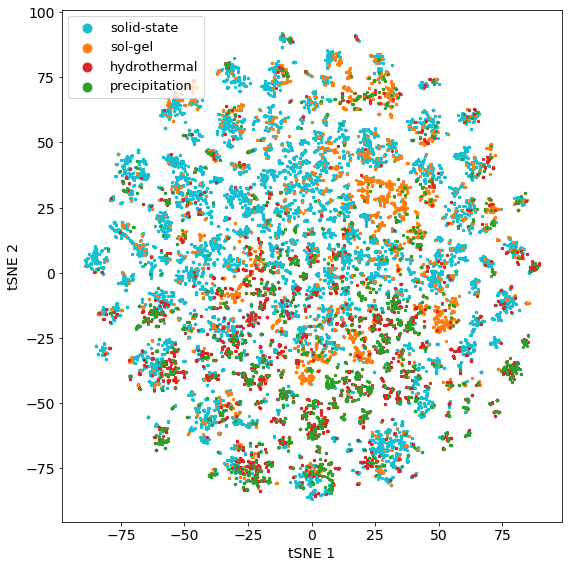

In [119]:
fig, ax = plt.subplots(figsize=(8, 8))
for color, label, x in zip(['C9', 'C1', 'C3', 'C2'], ["solid-state", "sol-gel", "hydrothermal", "precipitation"], [ss_tsne, sg_tsne, hyd_tsne, prec_tsne]):
    ax.scatter(x[:, 0], x[:, 1], c=color, label=label, s=5)

ax.set_xlabel("tSNE 1", fontsize=14)
ax.set_ylabel("tSNE 2", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.legend(fontsize=13, loc="upper left", markerscale=4)
fig.tight_layout()
plt.show()

fig.savefig('figures/tsne_mp_frac_4class_v3.png', dpi=150)

# Target only visualization, Magpie

In [66]:
X_target_TSNE = TSNE(n_components=2, init='random').fit_transform(X_transformed[:, :145])

In [67]:
sg_tar_tsne = []
ss_tar_tsne = []
hyd_tar_tsne = []
prec_tar_tsne = []
for i in range(X_target_TSNE.shape[0]):
    if y[i] == 0:
        # sg
        sg_tar_tsne.append(X_target_TSNE[i])
    elif y[i] == 1:
        # ss
        ss_tar_tsne.append(X_target_TSNE[i])
    elif y[i] == 2:
        hyd_tar_tsne.append(X_target_TSNE[i])
    else:
        # sol (2 = hydrothermal, 3 = precipitation)
        prec_tar_tsne.append(X_target_TSNE[i])
ss_tar_tsne = np.array(ss_tar_tsne)
sg_tar_tsne = np.array(sg_tar_tsne)
hyd_tar_tsne = np.array(hyd_tar_tsne)
prec_tar_tsne = np.array(prec_tar_tsne)

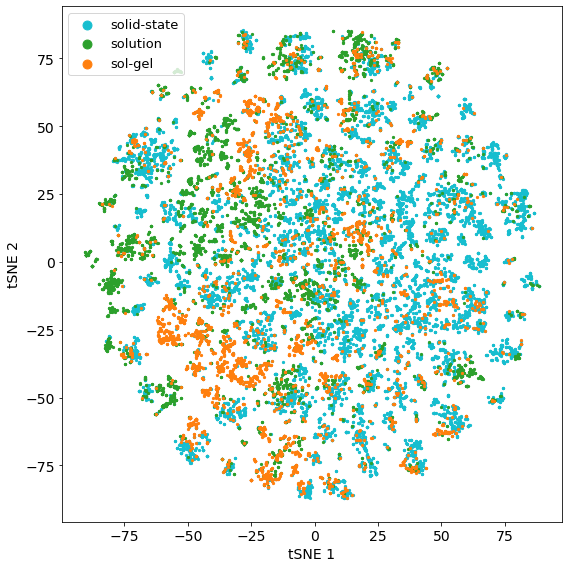

In [85]:
fig, ax = plt.subplots(figsize=(8, 8))
for color, label, x in zip(['C9', 'C2', 'C1'], ["solid-state", "solution",  "sol-gel"], [ss_tar_tsne, np.concatenate((hyd_tar_tsne, prec_tar_tsne), axis=0), sg_tar_tsne]):
    ax.scatter(x[:, 0], x[:, 1], c=color, label=label, s=5)

ax.set_xlabel("tSNE 1", fontsize=14)
ax.set_ylabel("tSNE 2", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.legend(fontsize=13, loc="upper left", markerscale=4)
fig.tight_layout()
plt.show()

fig.savefig('figures/tsne_tar_magpie_3class_v3.png', dpi=150)

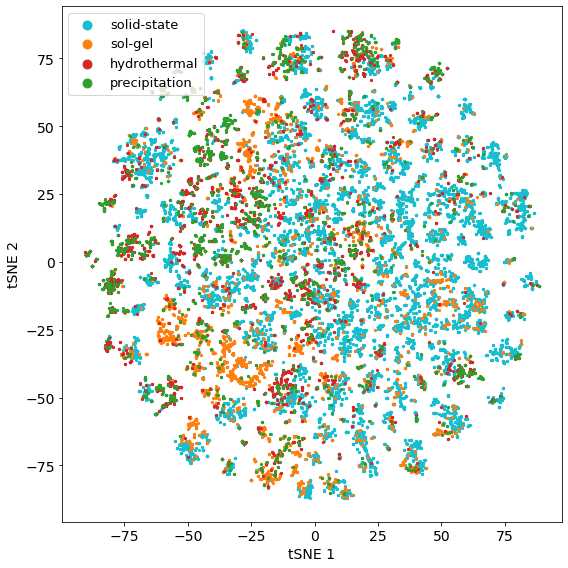

In [120]:
fig, ax = plt.subplots(figsize=(8, 8))
for color, label, x in zip(['C9', 'C1', 'C3', 'C2'], ["solid-state", "sol-gel", "hydrothermal", "precipitation"], [ss_tar_tsne, sg_tar_tsne, hyd_tar_tsne, prec_tar_tsne]):
    ax.scatter(x[:, 0], x[:, 1], c=color, label=label, s=5)

ax.set_xlabel("tSNE 1", fontsize=14)
ax.set_ylabel("tSNE 2", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.legend(fontsize=13, loc="upper left", markerscale=4)
fig.tight_layout()
plt.show()

fig.savefig('figures/tsne_tar_magpie_4class_v3.png', dpi=150)

In [87]:
print(ss_tar_tsne.shape, sg_tar_tsne.shape, prec_tar_tsne.shape, hyd_tar_tsne.shape, )

(15937, 2) (3979, 2) (2150, 2) (3362, 2)


# Prec Magpie rxn featurization visualization

In [88]:
lens = [len(x) for x in df["precursors"].values]
Counter(lens)

Counter({2: 8879, 3: 9915, 4: 5122, 5: 1166, 6: 275, 8: 17, 7: 53, 10: 1})

In [89]:
df_pca = df[df.precursors.str.len() <= 5]

In [90]:
df_pca.drop(columns=X_columns[145:], inplace=True)

In [91]:
unique_precs = dict()
for precs in df_pca["precursors"].values:
    for prec in precs:
        if prec not in unique_precs:
            unique_precs[prec] = feature_calculators.featurize(Composition(prec))

In [93]:
# do PCA on whole dataset rather than train/test splitting for visualization purposes

train_magpie_feats = []
train_precs = df_pca["precursors"].values
for precs in train_precs:
    feats = []
    for prec in precs:
        # check if nan
        if any(np.isnan(x) for x in unique_precs[prec]):
            feats.append(np.zeros(shape=(103)))
            continue
        feats.append(unique_precs[prec])
    for i in range(len(precs), 5):
        feats.append(np.zeros(shape=(103)))
    feats = np.array(feats)
    feats = feats.flatten()
    train_magpie_feats.append(feats)
train_magpie_feats = np.array(train_magpie_feats)

In [94]:
train_magpie_feats.shape

(25082, 515)

# Target + precursor rxn visualization

In [95]:
df_prec_magpie = pd.DataFrame(train_magpie_feats)

In [96]:
df_pca

,targets,precursors,labels,labels_multiclass,composition_obj,H,He,Li,Be,B,...,O_prec,C_prec,Org_prec,Ac_prec,Elem_prec,Other_prec,feature_exp_min_mp,feature_exp_max_mp,feature_exp_mean_mp,feature_exp_div_mp
0,Nb9PO25,"[Nb2O5, PH6NO4]",1.0,1.0,"(Nb, P, O)",0.000000,0,0.000000,0.0,0.0,...,0.500000,0.0,0.000000,0.0,0.0,0.0,190.00,1520.0,855.000000,1330.00
1,Li1Mn1.7Fe0.3O4,"[FeHO2, LiHO, MnCO3]",1.0,1.0,"(Li, Mn, Fe, O)",0.000000,0,0.142857,0.0,0.0,...,0.666667,0.0,0.000000,0.0,0.0,0.0,179.00,680.0,353.000000,501.00
2,Li1Ti0.05Ni0.95O2,"[LiHO, Ni(HO)2, TiO2]",1.0,1.0,"(Li, Ti, Ni, O)",0.000000,0,0.250000,0.0,0.0,...,1.000000,0.0,0.000000,0.0,0.0,0.0,230.00,1855.0,921.666667,1625.00
3,NdCoO3,"[Co3O4, Nd2O3]",1.0,1.0,"(Nd, Co, O)",0.000000,0,0.000000,0.0,0.0,...,1.000000,0.0,0.000000,0.0,0.0,0.0,947.00,2272.0,1609.500000,1325.00
4,Sr0.4Pr0.6Co1O3,"[Co2O3, Pr6O11, SrCO3]",1.0,1.0,"(Sr, Pr, Co, O)",0.000000,0,0.000000,0.0,0.0,...,0.666667,0.0,0.000000,0.0,0.0,0.0,150.00,2183.0,1276.666667,2033.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25423,BiClO,"[BiCl3, HCl]",2.0,3.0,"(Bi, Cl, O)",0.000000,0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,-114.22,230.0,57.890000,344.22
25424,Y3Al5O12,"[Al(NO3)3, Y2O3]",2.0,3.0,"(Y, Al, O)",0.000000,0,0.000000,0.0,0.0,...,0.500000,0.0,0.000000,0.0,0.0,0.0,73.00,2439.0,1256.000000,2366.00
25425,LiLa(PO3)4,"[La2O3, Li2CO3, PH9(NO2)2]",2.0,3.0,"(Li, La, P, O)",0.000000,0,0.055556,0.0,0.0,...,0.333333,0.0,0.000000,0.0,0.0,0.0,155.00,2315.0,1065.333333,2160.00
25426,Ca5P3HO13,"[CaO, PH3O4]",2.0,3.0,"(Ca, P, H, O)",0.045455,0,0.000000,0.0,0.0,...,0.500000,0.0,0.000000,0.0,0.0,0.0,89.00,2927.0,1508.000000,2838.00


In [97]:
df_prec_magpie

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,512,513,514
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.714286,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.250000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.500000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.333333,0.0,0.333333,0.0,0.0,0.0,0.000000,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.571429,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.600000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25077,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25078,0.000000,0.0,0.000000,0.0,0.0,0.0,0.230769,0.692308,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25079,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.600000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25080,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.500000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
df_pca.reset_index(drop=True, inplace=True)

In [99]:
df_rxn_magpie = pd.concat([df_pca, df_prec_magpie], axis=1)

In [100]:
df_rxn_magpie.tail()

,targets,precursors,labels,labels_multiclass,composition_obj,H,He,Li,Be,B,...,505,506,507,508,509,510,511,512,513,514
25077,BiClO,"[BiCl3, HCl]",2.0,3.0,"(Bi, Cl, O)",0.000000,0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25078,Y3Al5O12,"[Al(NO3)3, Y2O3]",2.0,3.0,"(Y, Al, O)",0.000000,0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25079,LiLa(PO3)4,"[La2O3, Li2CO3, PH9(NO2)2]",2.0,3.0,"(Li, La, P, O)",0.000000,0,0.055556,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25080,Ca5P3HO13,"[CaO, PH3O4]",2.0,3.0,"(Ca, P, H, O)",0.045455,0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25081,Zn0.5Fe2Ni0.5O4,"[Fe(NO3)3, NiH6(CO)4, ZnH6(CO)4]",2.0,3.0,"(Zn, Fe, Ni, O)",0.000000,0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
omit_columns = ['targets', 'precursors', 'labels', 'labels_multiclass', 'composition_obj']
X_columns = [x for x in df_rxn_magpie.columns if x not in omit_columns]
y_column = 'labels_multiclass'
X_rxn_magpie = df_rxn_magpie[X_columns].values
y_rxn_magpie = df_rxn_magpie[y_column].values
print("Shape of X: {}".format(X_rxn_magpie.shape))
print("Shape of y: {}".format(y_rxn_magpie.shape))

Shape of X: (25082, 651)
Shape of y: (25082,)


In [102]:
X_rxn_magpie

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.14285714, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.25      , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.05555556, ..., 0.        , 0.        ,
        0.        ],
       [0.04545455, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [103]:
X_rxn_magpie_transformed = StandardScaler().fit_transform(X_rxn_magpie)

In [104]:
rxn_magpie_tsne = TSNE(n_components=2, init='random').fit_transform(X_rxn_magpie_transformed)

In [105]:
sg_tsne_mag = []
ss_tsne_mag = []
hyd_tsne_mag = []
prec_tsne_mag = []
for i in range(rxn_magpie_tsne.shape[0]):
    if y[i] == 0:
        # sg
        sg_tsne_mag.append(rxn_magpie_tsne[i])
    elif y[i] == 1:
        # ss
        ss_tsne_mag.append(rxn_magpie_tsne[i])
    elif y[i] == 2:
        # hydrothermal
        hyd_tsne_mag.append(rxn_magpie_tsne[i])
    else:
        prec_tsne_mag.append(rxn_magpie_tsne[i])
        
ss_tsne_mag = np.array(ss_tsne_mag)
sg_tsne_mag = np.array(sg_tsne_mag)
hyd_tsne_mag = np.array(hyd_tsne_mag)
prec_tsne_mag = np.array(prec_tsne_mag)

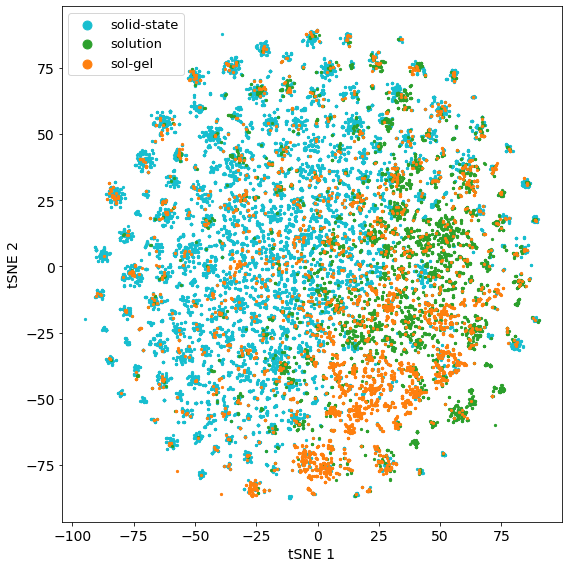

In [113]:
fig, ax = plt.subplots(figsize=(8, 8))
for color, label, x in zip(['C9', 'C2', 'C1'], ["solid-state", "solution",  "sol-gel"], [ss_tsne_mag, np.concatenate((hyd_tsne_mag, prec_tsne_mag), axis=0), sg_tsne_mag]):
    ax.scatter(x[:, 0], x[:, 1], c=color, label=label, s=5)
    
ax.set_xlabel("tSNE 1", fontsize=14)
ax.set_ylabel("tSNE 2", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.legend(fontsize=13, loc="upper left", markerscale=4)
fig.tight_layout()
plt.show()

fig.savefig('figures/tsne_magpie_rxn_3class_v3.png', dpi=150)

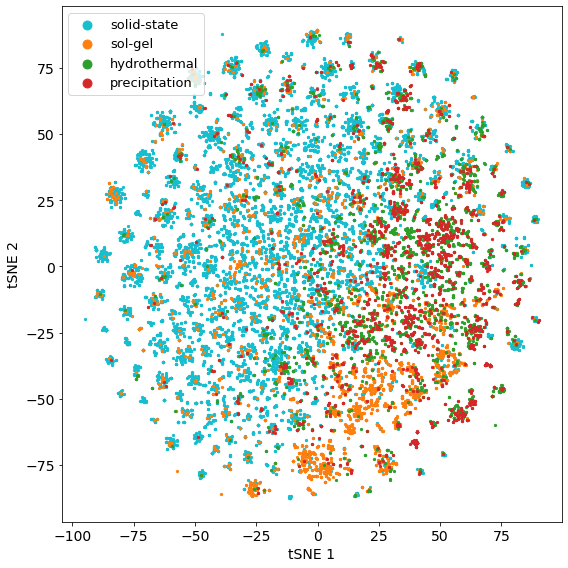

In [121]:
fig, ax = plt.subplots(figsize=(8, 8))
for color, label, x in zip(['C9', 'C1', 'C2', 'C3'], ["solid-state", "sol-gel", "hydrothermal", "precipitation"], [ss_tsne_mag, sg_tsne_mag, hyd_tsne_mag, prec_tsne_mag]):
    ax.scatter(x[:, 0], x[:, 1], c=color, label=label, s=5)
    
ax.set_xlabel("tSNE 1", fontsize=14)
ax.set_ylabel("tSNE 2", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.legend(fontsize=13, loc="upper left", markerscale=4)
fig.tight_layout()
plt.show()

fig.savefig('figures/tsne_magpie_rxn_4class_v3.png', dpi=150)

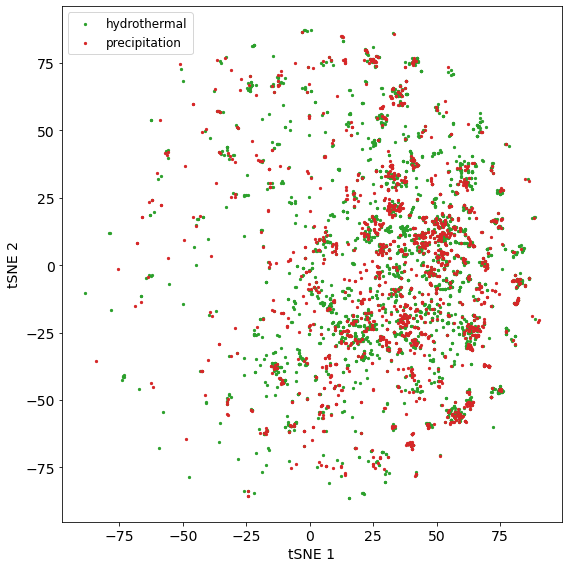

In [108]:
fig, ax = plt.subplots(figsize=(8, 8))
for color, label, x in zip(['C2', 'C3'], ["hydrothermal", "precipitation"], [hyd_tsne_mag, prec_tsne_mag]):
    ax.scatter(x[:, 0], x[:, 1], c=color, label=label, s=5)
    
ax.set_xlabel("tSNE 1", fontsize=14)
ax.set_ylabel("tSNE 2", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.legend(fontsize=12, loc="upper left")
fig.tight_layout()
plt.show()

# fig.savefig('figures/tsne_magpie_rxn_4class.png', dpi=150)